# Metal Detection of Vehicle Prediction

## Using 6-Sigma Approach for fewer data points

In [11]:
# Future Imports
from __future__ import unicode_literals
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

# Data Cleaning
from pandas import DataFrame, Series, read_csv, rolling_mean, concat
from numpy import random, concatenate, tile
from scipy import stats

# Visulization
import matplotlib.pyplot as plt
%matplotlib inline

# Time
import time

# Model Building
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [12]:
# For checking the execution time
def timeit(method):
    '''decorator which checks the execution time of a function
       parameters
       ----------
       method: functions
       Return
       ----------
       time
    '''
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

In [13]:
@timeit
def vehicle_dataframe(filepath):
    '''creating dataframe from csv file
       Parameters
       ----------
       method: relative filepath
       Return
       ----------
       dataframe
    '''
    dataframe = read_csv(filepath)
    return dataframe

dataframe = vehicle_dataframe('./train.csv')
dataframe

'vehicle_dataframe'  1.96 ms


,time,amp_read,vehicle
0,1,0.00,-
1,2,-0.05,-
2,3,0.10,-
3,4,0.50,Motorbike
4,5,0.40,Motorbike
5,6,0.00,-
6,7,1.50,Bus
7,8,1.55,Bus
8,9,1.29,Bus
9,10,1.62,Bus


## Statiscal Summary

In [14]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 3 columns):
time        17 non-null int64
amp_read    17 non-null float64
vehicle     17 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 480.0+ bytes


In [15]:
dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
time,17.0,9.000000,5.049752,1.00,5.0,9.0,13.00,17.00
amp_read,17.0,1.355882,1.960718,-0.09,0.0,0.4,1.55,5.66


In [16]:
# Categorical Variable
dataframe.describe(include=['O'])

,vehicle
count,17
unique,4
top,-
freq,8


## We will find the 6-sigma of the vehicle classes and check whether the data points lie inside this range

#### 6-Sigma in a Normal Distribution gives the 99.997% Accuracy score. Therefore, all the points lie in this range are correctly predicted with the above accuracy. After that we will check if the points lie near to the 'mean' of these classes. If they are particularly near to one class or lie in between one class's range, they are classified as the data point of that class.

In [17]:
@timeit
def sixsigma_for_vehicle_class(data):
    '''calculates sixsigma for the vehicle classes
       Parameters
       ----------
       method: dataframe
       Return
       ----------
       tuple of sixsigma value
    '''
    mean = data[data['vehicle'] != '-'].groupby('vehicle')['amp_read'].mean()
    std = data[data['vehicle'] != '-'].groupby('vehicle')['amp_read'].std()
    sixsigma = mean - 3 * std, mean + 3 * std
    return sixsigma

minimum_sixsigma = sixsigma_for_vehicle_class(dataframe)[0]
maximum_sixsigma = sixsigma_for_vehicle_class(dataframe)[1]
for i in range(len(minimum_sixsigma)):
    Bus = (minimum_sixsigma[i], maximum_sixsigma[i])
    Car = (minimum_sixsigma[i+1], maximum_sixsigma[i+1])
    Motorbike = (minimum_sixsigma[i+2], maximum_sixsigma[i+2])
    break
    
minimum_sixsigma

'sixsigma_for_vehicle_class'  4.10 ms
'sixsigma_for_vehicle_class'  4.83 ms


vehicle
Bus          1.063620
Car          3.498067
Motorbike    0.237868
Name: amp_read, dtype: float64

In [18]:
maximum_sixsigma

vehicle
Bus          1.916380
Car          6.995266
Motorbike    0.662132
Name: amp_read, dtype: float64

In [19]:
@timeit
def sixsigma_for_non_vehicle_class(data):
    '''calculates sixsigma for the non classed vehicle
       Parameters
       ----------
       method: dataframe
       Return
       ----------
       tuple of sixsigma value
    '''
    mean = data[data['vehicle'] == '-'].groupby('vehicle')['amp_read'].mean()
    std = data[data['vehicle'] == '-'].groupby('vehicle')['amp_read'].std()
    sixsigma2 = mean - 3 * std, mean + 3 * std
    return sixsigma2

sixsigma_for_non_vehicle_class(dataframe)

'sixsigma_for_non_vehicle_class'  4.39 ms


(vehicle
 -   -0.345263
 Name: amp_read, dtype: float64, vehicle
 -    0.457763
 Name: amp_read, dtype: float64)

#### We will consider those points which are below 0 as noise or disturbance as a reading cannot be negative in real scenerio.
#### Therefore, from the above approach, we can conclude that the points which are not recorded lie between Bike's sixsigma and hence classified as Bike.

## Using Machine Learning Model when 6-Sigma intervals Intersect

#### Since the data points are less, another approach is to create your own dataset with more data points and build a Machine Learning Model on it.

In [23]:
# Creating Sample Dataset
@timeit
def sample_dataset():
    ''' Creates a sample dataset
    Parameters
    ----------
    method: None
    Return
    ----------
    dataframe
    '''
    bike = random.normal(0.5, 0.2, size=100)
    car = random.normal(5.5, 0.3, size=100)
    bus = random.normal(3.5, 0.4, size=100)
    amp_read = concatenate((bike, car, bus), axis=0)
    bike = tile('bike', 100)
    car = tile('car', 100)
    bus = tile('bus', 100)
    vehicle = concatenate((bike, car, bus), axis=0)
    dictionary = {'amp_read': amp_read, 'vehicle': vehicle}
    dataframe = DataFrame(data=dictionary)
    data = dataframe.sample(frac=1.0, random_state=42)
    data.reset_index(drop=True, inplace=True)
    return data

data = sample_dataset()

'sample_dataset'  36.78 ms


In [24]:
# Empty Dataframe
dataframe_sampled_points = DataFrame({'vehicle_type': [], 'amp_reading': []})

In [33]:
# Creating a Random choice of data points
def vehicle_column(choice):
    ''' Randomly chooses the rows from dataframe based on the choice
    Parameters
    ----------
    method: string
    Return
    ----------
    integer
    '''
    if choice == 'bike':
        return random.choice([1, 2], p = [0.9, 0.1])
    elif choice == 'car':
        return random.choice([2, 3, 4], p = [0.35, 0.6, 0.05])
    elif choice == 'bus':
        return random.choice([3, 4, 5], p = [0.05, 0.9, 0.05])

In [34]:
def sample_dataset(vehicle_type):
    ''' Takes the integer value and creates a dataframe based on that
        with a normal distribution.
        Parameters
        ----------
        method: string
        Return
        ----------
        dataframe
    '''
    reps = vehicle_column(vehicle_type)
    vehicle_type_list = reps*[vehicle_type]
    if vehicle_type == 'bike':
        readings_list = list(random.normal(0.5, 0.2, reps))
    elif vehicle_type == 'car':
        readings_list = list(random.normal(5.5, 0.3, reps))
    elif vehicle_type == 'bus':
        readings_list = list(random.normal(3.5, 0.4, reps))
    temporary_dataframe = DataFrame({'vehicle_type':vehicle_type_list,
                         'amp_reading':readings_list})
    return temporary_dataframe

In [35]:
# Appends in the empty dataframe we created
for count in range(1,301):
    choice = random.choice(data.vehicle.unique(), p=[0.333,0.333,0.334])
    if choice == 'bike':
        dataframe_sampled_points = dataframe_sampled_points.append(sample_dataset(choice))
    elif choice == 'car':
        dataframe_sampled_points = dataframe_sampled_points.append(sample_dataset(choice))
    elif choice == 'bus':
        dataframe_sampled_points = dataframe_sampled_points.append(sample_dataset(choice))

In [36]:
# Resetting index
dataframe_sampled_points = dataframe_sampled_points.reset_index(drop=True)
dataframe_sampled_points.head(10)

,amp_reading,vehicle_type
0,5.265465,car
1,5.402927,car
2,5.270011,car
3,5.976650,car
4,5.494549,car
5,5.307034,car
6,5.589427,car
7,3.403122,bus
8,3.194586,bus
9,3.434955,bus


#### To see if the intervals are not overlapping, we will create 6 new features taking averages and ratio of the ampere reading.

In [37]:
def feature_engineering(dataframe):
    ''' Creates six new features
        Parameters
        ----------
        method: dataframe
        Return
        ----------
        None
    '''
    dataframe['avg_of_two_val'] = dataframe.amp_reading.rolling(2).mean()
    dataframe['avg_of_three_val'] = dataframe.amp_reading.rolling(3).mean()
    dataframe['avg_of_four_val'] = dataframe.amp_reading.rolling(4).mean()
    dataframe['ratio_of_two_val'] = dataframe.amp_reading.iloc[:] / dataframe.avg_of_two_val.iloc[:]
    dataframe['ratio_of_three_val'] = dataframe.amp_reading.iloc[:] / dataframe.avg_of_three_val.iloc[:]
    dataframe['ratio_of_four_val'] = dataframe.amp_reading.iloc[:] / dataframe.avg_of_four_val.iloc[:]

feature_engineering(dataframe_sampled_points)
dataframe_sampled_points.head(10)

,amp_reading,vehicle_type,avg_of_two_val,avg_of_three_val,avg_of_four_val,ratio_of_two_val,ratio_of_three_val,ratio_of_four_val
0,5.265465,car,NaN,NaN,NaN,NaN,NaN,NaN
1,5.402927,car,5.334196,NaN,NaN,1.012885,NaN,NaN
2,5.270011,car,5.336469,5.312801,NaN,0.987546,0.991946,NaN
3,5.976650,car,5.623330,5.549863,5.478763,1.062831,1.076901,1.090876
4,5.494549,car,5.735600,5.580403,5.536034,0.957973,0.984615,0.992506
5,5.307034,car,5.400791,5.592744,5.512061,0.982640,0.948914,0.962804
6,5.589427,car,5.448230,5.463670,5.591915,1.025916,1.023017,0.999555
7,3.403122,bus,4.496274,4.766528,4.948533,0.756876,0.713962,0.687703
8,3.194586,bus,3.298854,4.062378,4.373542,0.968393,0.786383,0.730435
9,3.434955,bus,3.314771,3.344221,3.905522,1.036257,1.027132,0.879512


In [51]:
# Missing Value Imputation
dataframe_sampled_points.fillna(0, inplace=True)
dataframe_sampled_points.shape

(761, 8)

#### We will plot graphs for all the feature we created and check how they are distinguishing each point from another.

'graphs_and_plots'  372.10 ms


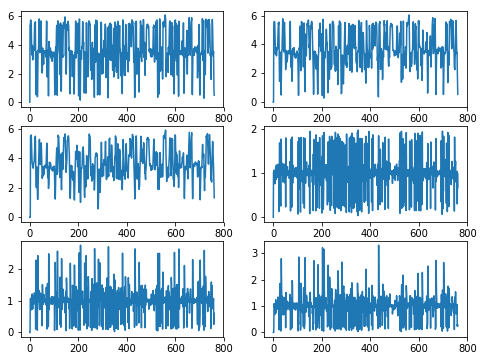

In [41]:
@timeit
def graphs_and_plots(dataframe):
    ''' Plots line graphs for feature created
        Parameters
        ----------
        method: dataframe
        Return
        ----------
        None
    '''
    fig, ax = plt.subplots(3,2, figsize=(8,6))
    ax[0][0].plot(dataframe.avg_of_two_val)
    ax[0][1].plot(dataframe.avg_of_three_val)
    ax[1][0].plot(dataframe.avg_of_four_val)
    ax[1][1].plot(dataframe.ratio_of_two_val)
    ax[2][0].plot(dataframe.ratio_of_three_val)
    ax[2][1].plot(dataframe.ratio_of_four_val)
    
graphs_and_plots(dataframe_sampled_points)

#### The Graph clearly shows the difference between two data points in our dataset.
#### We can now easily build our model and learn on this dataset.

In [44]:
feature = dataframe_sampled_points[['amp_reading', 'avg_of_two_val', 'avg_of_three_val', \
                                    'avg_of_four_val', 'ratio_of_two_val', \
                                    'ratio_of_three_val', 'ratio_of_four_val']]
target = dataframe_sampled_points['vehicle_type']

In [63]:
# Cross Validation
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.3)
X_test.shape

(229, 7)

In [62]:
# Creating the Model
@timeit
def model():
    ''' Builds the model
        Parameters
        ----------
        method: None
        Return
        ----------
        RandomForestClassifier
    '''
    clf = RandomForestClassifier(n_estimators=100, max_depth=3)
    return clf
clf = model()

'model'  0.04 ms


In [59]:
# Making Predictions
@timeit
def prediction(clf):
    ''' makes the predictions on the train and test
        Parameters
        ----------
        method: model
        Return
        ----------
        float
    '''
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    return accuracy_score(y_test, prediction)

In [60]:
prediction(clf)

'prediction'  480.77 ms


0.98689956331877726

### If there are multiple plates, they will have different readings for different classes of vehicle. Since Bike is less than 1 Feet, the reading recorded will be close to each other with a marignal difference, therefore our model will easily be able to classify.  But for Cars and Bus, the readings will vary a lot. Therefore, in that case, we will first take the average value of the activated slab and then differentiate with other metal slabs.

### If a vehicle's speed is 60km/hr, our model will perform better as there will be single readings at that time and also we will have 6 values for bus-car, car-bike etc.